In [1]:
import os
import csv
import platform
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

run_metrics = True

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "MODULARITY", "LONELINESS", "NETWORK PERMANENCE", "NORM. MUTUAL INFO", "EDGE CUT WEIGHT", "FSCORE", "FSCORE RELABEL IMPROVEMENT"]
pwd = %pwd

config = {
    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "rand_edge_weights", "network_1.txt"),
    #"DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_1.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "PATOH",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    "PARTITIONER_ALGORITHM": "PATOH",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_90",
                                           "arrival_90_1.txt"
                                          ),
    
    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_1.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_1.txt"
                                            ),

    # Number of shelters
    "num_partitions": 4,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.0,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 40,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,

    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": False,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,

    # Enables edge expansion when graph_modification_functions is set to true
    "edge_expansion_enabled": True,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    # This applies the prediction_list_file node weights onto the nodes in the graph
    # when the prediction model is being computed and then removes the weights
    # for the cutoff and batch arrival modes
    "apply_prediction_model_weights": True,

    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,
        
    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    "PATOH_HYPEREDGE_EXPANSION_MODE": 'avg_node_weight',

    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 1
}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2938
Average degree:   5.8760
Graph is undirected


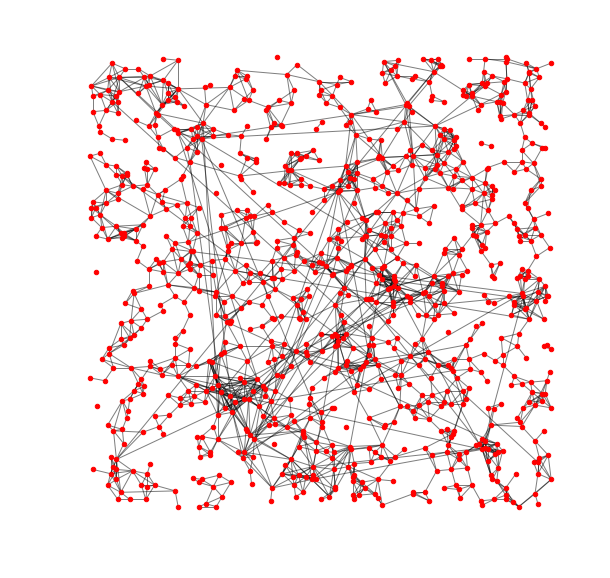

In [3]:
pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')

nx.draw_networkx_nodes(gp.G, pos, node_size=20, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

In [4]:
gp.init_partitioner()

PaToH partitioner loaded for generating PREDICTION MODEL.
PaToH partitioner loaded for making shelter assignments.


## PaToH Hyperedge Expansion Modes

In [5]:
test_all_expansion_modes = False
if test_all_expansion_modes:
    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    
    expansion_modes = ['no_expansion', 
                       'avg_edge_weight', 
                       'total_edge_weight',
                       'smallest_edge_weight',
                       'largest_edge_weight',
                       'avg_edge_weight_squared', 
                       'total_edge_weight_squared',
                       'smallest_edge_weight_squared',
                       'largest_edge_weight_squared',
                       'avg_edge_weight_sqrt', 
                       'total_edge_weight_sqrt',
                       'smallest_edge_weight_sqrt',
                       'largest_edge_weight_sqrt']
    
    was_quiet = gp._quiet
    gp._quiet = True
    for expansionMode in expansion_modes:
        print('Expansion Mode:', expansionMode)
        # reset data
        gp.reset()
        
        # change the expansion mode
        gp.prediction_model_algorithm.hyperedgeExpansionMode = expansionMode
        gp.prediction_model_algorithm.partitioningIterations = 50
        # run the partitioner
        m = gp.prediction_model()
        
        # data
        rows = list(range(1, len(m)+1))
        df = pd.DataFrame(m, index=rows, columns=cols)
        print(df)
        print('\n\n')
    gp._quiet = was_quiet
    gp.reset()
    gp.prediction_model_algorithm.hyperedgeExpansionMode = gp.PATOH_HYPEREDGE_EXPANSION_MODE
    gp.prediction_model_algorithm.partitioningIterations = gp.PATOH_ITERATIONS        

# Prediction Model

In [6]:
m = gp.prediction_model()

Ran PaToH for 5 iterations with min_cuts = 153 and max_cuts = 210  - picked min_cuts assignements.
PREDICTION MODEL
----------------

Hungarian rows [0 1 2 3]
Hungarian cols [0 1 2 3]

Assignments:
[ 3  2  2  3  2  3  3  1  0  0  3  1  2  1  3  3  3  1  0  1  1  3  3  1  1  1  1  3  3  1  2  3  2  3  3  2  3  3  2  3  0  2  1  1  3  3  3  1  1  3  1  3  3  2  3  1  1  0  3  3  3  0  3  2  1  1  1  2  3  3  0  3  3  3  1  1  3  3  2  3  3  0  3  2  3  1  0  0  1  3  3  3  1  1  3  3  2  3  2  2  1  3  3  3  3  3  2  0  3  3  3  2  2  0  3  2  3  1  3  3  2  2  1  3  3  3  2  3  2  3  1  1  3  3  0  3  1  3  3  1  0  3  3  1  3  3  2  1  1  3  3  1  3  2  3  2  1  2  1  3  0  3  1  1  2  1  3  3  3  3  0  2  3  3  1  1  2  1  2  3  0  3  3  3  3  3  3  3  1  1  3  2  3  1  3  1  3  3  0  2  1  2  3  2  3  3  1  3  2  3  2  2  1  2  3  3  3  3  1  3  1  1  3  0  3  2  3  3  1  3  3  3  1  3  3  1  3  3  2  2  3  1  0  1  3  3  3  3  3  3  3  1  3  3  2  3  2  3  3  3  3  2  1  3  3  3  3 

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1  1.067   0.052076        153                182    0.834763         0.0   

  NETWORK PERMANENCE  NORM. MUTUAL INFO  EDGE CUT WEIGHT  FSCORE  \
1           0.379307                1.0             1605     1.0   

   FSCORE RELABEL IMPROVEMENT  
1                         0.0  


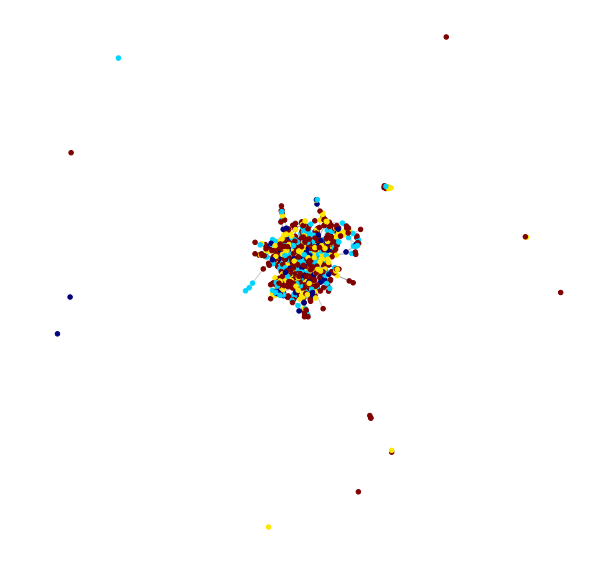

In [7]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

pos = nx.spring_layout(gp.G)
plt.figure(figsize=(10, 10))
plt.axis('off')
colours = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

colour = []
#for n in gp.G.nodes_iter():
#    colour += [colours[gp.assignments[n]]]

nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=gp.assignments, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.2)
plt.show(gp.G)

# Assign Cut Off

In [8]:
m = gp.assign_cut_off()

Discarding prediction model

Hungarian rows [0 1 2 3]
Hungarian cols [0 1 2 3]

Assignments:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

In [9]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1      0        0.0          0                  0           0         0.0   

  NETWORK PERMANENCE  NORM. MUTUAL INFO  EDGE CUT WEIGHT  FSCORE  \
1                nan       5.551115e-07                0       0   

   FSCORE RELABEL IMPROVEMENT  
1                           0  


# Run Simulation

In [10]:
m = gp.batch_arrival()

Assigning in batches of 40
--------------------------------

Ran PaToH for 5 iterations with min_cuts = 0 and max_cuts = 0  - picked min_cuts assignements.
Hungarian rows [0 1 2 3]
Hungarian cols [2 1 0 3]
Ran PaToH for 5 iterations with min_cuts = 4 and max_cuts = 5  - picked min_cuts assignements.
Hungarian rows [0 1 2 3]
Hungarian cols [2 1 0 3]
Ran PaToH for 5 iterations with min_cuts = 15 and max_cuts = 16  - picked min_cuts assignements.
Hungarian rows [0 1 2 3]
Hungarian cols [2 1 0 3]
Ran PaToH for 5 iterations with min_cuts = 34 and max_cuts = 41  - picked min_cuts assignements.
Hungarian rows [0 1 2 3]
Hungarian cols [2 1 0 3]
Ran PaToH for 5 iterations with min_cuts = 72 and max_cuts = 82  - picked min_cuts assignements.
Hungarian rows [0 1 2 3]
Hungarian cols [2 1 0 3]
Ran PaToH for 5 iterations with min_cuts = 117 and max_cuts = 125  - picked min_cuts assignements.
Hungarian rows [0 1 2 3]
Hungarian cols [2 1 0 3]
Ran PaToH for 5 iterations with min_cuts = 173 and max_cuts

      WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME  MODULARITY  LONELINESS  \
1  0.000000   0.000000        0.0                0.0    0.231786         0.0   
2  0.000000   0.071429        4.0                7.0    0.634915         0.0   
3  0.000000   0.128205       15.0               24.0    0.724404         0.0   
4  0.000000   0.167488       34.0               50.0    0.743872         0.0   
5  0.000000   0.225705       72.0               94.0    0.756551         0.0   
6  0.016667   0.260000      117.0              144.0    0.776898         0.0   
7  0.003584   0.287854      173.0              191.0    0.783353         0.0   

   NETWORK PERMANENCE  NORM. MUTUAL INFO  EDGE CUT WEIGHT    FSCORE  \
1            1.000000           0.038878              0.0  0.329545   
2            1.000000           0.051601             28.0  0.392308   
3           -0.962617           0.063547            137.0  0.330072   
4           -0.962617           0.079000            329.0  0.306256   
5   

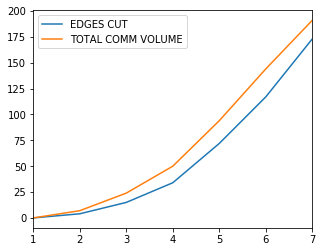

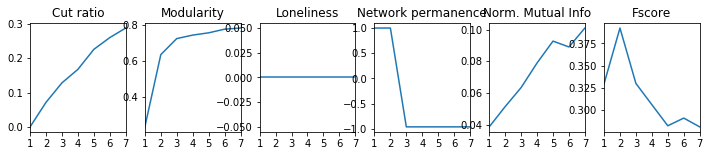

In [14]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols).astype(float)
print(df)

if len(df) > 1:
    df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=rows, figsize=(5,4))

    fig, axs = plt.subplots(1,6)
    df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=rows, figsize=(12,2), legend=False, ax=axs[0])
    df.plot(y=['MODULARITY'], title='Modularity', xticks=rows, figsize=(12,2), legend=False, ax=axs[1])
    df.plot(y=['LONELINESS'], title='Loneliness', xticks=rows, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['NETWORK PERMANENCE'], title='Network permanence', xticks=rows, figsize=(12,2), legend=False, ax=axs[3])
    df.plot(y=['NORM. MUTUAL INFO'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])
    df.plot(y=['FSCORE'], title='Fscore', xticks=rows, figsize=(12,2), legend=False, ax=axs[5])


else:
    print("\n\nNot enough data points to plot charts. There is only one row.")

# Network Visual

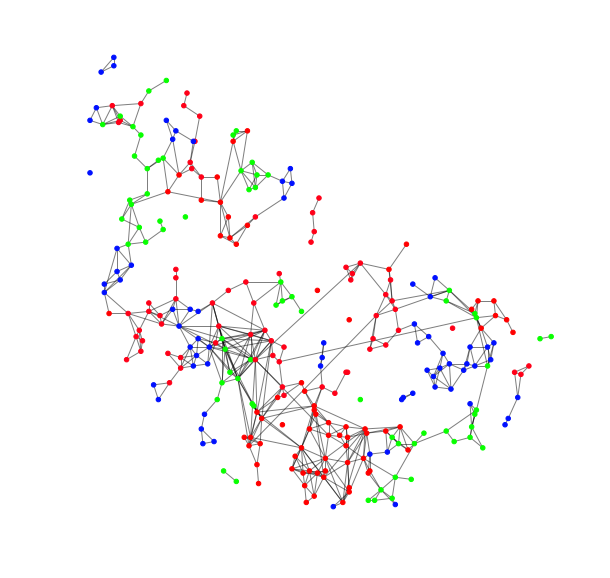

In [12]:
part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]

pos_spring = nx.spring_layout(gp.G, k=0.5, iterations=20)

pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

# create colours
cmap = utils.get_cmap(gp.num_partitions)
colours = np.zeros((gp.G.number_of_nodes(), 4), dtype=np.float)
for i,n in enumerate(gp.G.nodes_iter()):
    if gp.assignments[n] == -1:
        col = [(1.0, 1.0, 1.0, 1.0)]
    else:
        col = [cmap(gp.assignments[n])]
    colours[i] = np.array(col, dtype=np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=colours, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

#nx.draw_networkx_nodes(gp.G, pos_spring, node_size=20, node_color=colour, cmap=plt.cm.jet, with_labels=False)
#nx.draw_networkx_edges(gp.G, pos_spring, alpha=0.5)
#plt.show(gp.G)

# Metrics

In [13]:
if run_metrics:
    gp.get_metrics()

Complete graph with 1000 nodes

Config
-------

file: 193209
num_partitions: 4
num_iterations: 1
prediction_model_cut_off: 0.0
restream_batches: 40
use_virtual_nodes: False
virtual_edge_weight: 1.0
edges_cut: 173

Metrics
-------

waste: 0.0010000000000000009
cut_ratio: 0.2878535773710483
total_communication_volume: 191
network_permanence: -0.620997
Q: 0.7420762899414437
NQ: -1.2968197581442862
Qds: 0.09405706203738591
intraEdges: 303.65
interEdges: 35.7
intraDensity: 0.1535142918559899
modularity degree: 112.80500364922153
conductance: 0.5826082117904716
expansion: 11.570465460183964
contraction: 17.210715642645038
fitness: 0.3977921024441359
QovL: 0.9360623981702859

Partition 0 with 70 nodes
-----------------------------


Metrics
file: 193209
partition: 0
population: 70
Q: 0.06591363986114522
NQ: -5.359779747571086
Qds: -0.8785291548810588
intraEdges: 2.8181818181818183
interEdges: 51.74545454545454
intraDensity: 0.00440771349862259
modularity degree: -2820.166666666667
conductance